## Other

In [85]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull
from dtaidistance import dtw
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def calculate_polygone_area(trajectory1, trajectory2):
    """
    Calculate the area of a polygon using the Shoelace formula.
    
    Parameters:
    trajectory1 (np.ndarray): Ground truth trajectory of shape (L, 2).
    trajectory2 (np.ndarray): Generated trajectory of shape (L, 2).
    
    Returns:
    float: The area of the polygon.
    
    Problems:
    Works with a polygon that does not intersect itself
    """
    points = np.concatenate((trajectory1, trajectory2[::-1]), axis=0)
    
    # Ensure that the polygon is closed
    if not np.array_equal(points[0], points[-1]):
        points = np.vstack([points, points[0]])
    
    x = points[:, 0]
    y = points[:, 1]
    
    area = 0.5 * np.abs(np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:]))
    return area

def calculate_diff_distance_traveled(trajectory1, trajectory2):
    """
    Calculate the absolute difference of total distances traveled by two trajectories.

    Parameters:
    trajectory1 (np.ndarray): Trajectory of shape (L, 2).
    trajectory2 (np.ndarray): Generated trajectory of shape (L, 2).

    Returns:
    float: Total distance traveled.
    """
    distances_gen = np.linalg.norm(np.diff(trajectory1, axis=0), axis=1)
    distances_gt = np.linalg.norm(np.diff(trajectory2, axis=0), axis=1)
    
    return np.abs(np.sum(distances_gen) - np.sum(distances_gt))


def calculate_frechet_distance(trajectory1, trajectory2):
    """
    Calculate the Frechet Distance between two trajectories.

    Parameters:
    trajectory1 (np.ndarray): Ground truth trajectory of shape (L, 2).
    trajectory2 (np.ndarray): Generated trajectory of shape (L, 2).

    Returns:
    float: Frechet distance.
    """
    ca = np.full((len(trajectory1), len(trajectory2)), -1.0)

    def _c(i, j):
        if ca[i, j] > -1:
            return ca[i, j]
        if i == 0 and j == 0:
            ca[i, j] = euclidean(trajectory1[0], trajectory2[0])
        elif i > 0 and j == 0:
            ca[i, j] = max(_c(i-1, 0), euclidean(trajectory1[i], trajectory2[0]))
        elif i == 0 and j > 0:
            ca[i, j] = max(_c(0, j-1), euclidean(trajectory1[0], trajectory2[j]))
        elif i > 0 and j > 0:
            ca[i, j] = max(min(_c(i-1, j), _c(i-1, j-1), _c(i, j-1)), euclidean(trajectory1[i], trajectory2[j]))
        else:
            ca[i, j] = float('inf')
        return ca[i, j]

    return _c(len(trajectory1) - 1, len(trajectory2) - 1)


def calculate_ade_fde(ground_truth, generated_trajectories):
    """
    Calculate Average Displacement Error (ADE) and Final Displacement Error (FDE).

    Parameters:
    ground_truth (np.ndarray): Ground truth trajectory of shape (L, 2).
    generated_trajectories (list of np.ndarray): List of generated trajectories, each of shape (L, 2).

    Returns:
    float, float: ADE, FDE.
    """
    ade = np.mean([np.mean(np.linalg.norm(ground_truth - generated_trajectories, axis=1))])
    fde = np.mean([np.linalg.norm(ground_truth[-1] - generated_trajectories[-1])])
    return ade, fde


def interpolate_to_fixed_length(trajectory, num_timesteps, kind):
    """
    Interpolate a variable-length trajectory to a fixed number of timesteps.

    Parameters:
    trajectory (np.ndarray): Input trajectory of shape (L, 2), where L is the number of timesteps.
    num_timesteps (int): The number of timesteps to interpolate to (default is 10).
    kind: choose from 'linear', 'quadratic', 'cubic'.
    Returns:
    np.ndarray: Interpolated trajectory of shape (num_timesteps, 2).
    """
    L = trajectory.shape[0]  # Original length of the trajectory

    # Original timesteps
    original_timesteps = np.linspace(0, L - 1, L)

    # New timesteps to interpolate to
    new_timesteps = np.linspace(0, L - 1, num_timesteps)

    # Interpolated trajectory
    interpolated_trajectory = np.zeros((num_timesteps, 2))

    # Interpolate x and y separately
    for i in range(2):  # for each dimension x and y
        interp_func = interp1d(original_timesteps, trajectory[:, i], kind=kind, fill_value='extrapolate')
        interpolated_trajectory[:, i] = interp_func(new_timesteps)

    return interpolated_trajectory

area = calculate_polygone_area(gt, gen1)
diff_dist_travelled = calculate_diff_distance_traveled(gen1, gt)
frechet_dist = calculate_frechet_distance(gt, gen1)
ade, fde = calculate_ade_fde(gt, gen1)
print(f"Polygone Area: {area}, ABS Difference Distance Travelled: {diff_dist_travelled}, Frechet Distance: {frechet_dist}, ADE: {ade}, FDE: {fde}")

area = calculate_polygone_area(gt, gen2)
diff_dist_travelled = calculate_diff_distance_traveled(gen2, gt)
frechet_dist = calculate_frechet_distance(gt, gen2)
ade, fde = calculate_ade_fde(gt, gen2)
print(f"Polygone Area: {area}, ABS Difference Distance Travelled: {diff_dist_travelled}, Frechet Distance: {frechet_dist}, ADE: {ade}, FDE: {fde}")

area = calculate_polygone_area(gt, gen3)
diff_dist_travelled = calculate_diff_distance_traveled(gen3, gt)
frechet_dist = calculate_frechet_distance(gt, gen3)
ade, fde = calculate_ade_fde(gt, gen3)
print(f"Polygone Area: {area}, ABS Difference Distance Travelled: {diff_dist_travelled}, Frechet Distance: {frechet_dist}, ADE: {ade}, FDE: {fde}")

Polygone Area: 0.05538295802034554, ABS Difference Distance Travelled: 0.26881030823689933, Frechet Distance: 0.31987135161406505, ADE: 0.17046654750934853, FDE: 0.31987135161406505
Polygone Area: 1.887793651643733, ABS Difference Distance Travelled: 6.4585741258609595, Frechet Distance: 6.477368133657983, ADE: 3.000282954596517, FDE: 6.477368133657982
Polygone Area: 3.138056192161457, ABS Difference Distance Travelled: 5.20681969275063, Frechet Distance: 6.112312854737206, ADE: 2.6148586937112994, FDE: 6.112312854737206


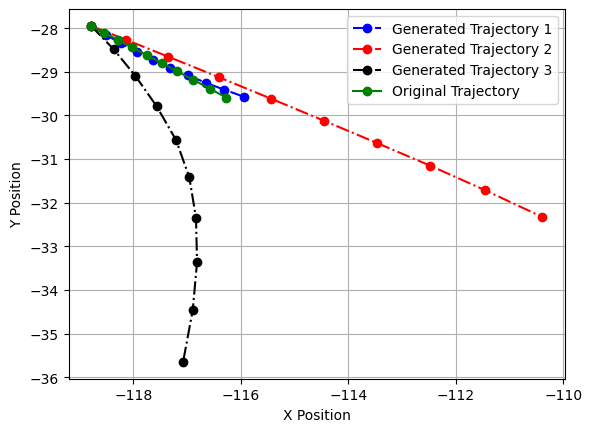

In [83]:
# Example trajectory of shape (L, 2)
num_timesteps, kind = 10, 'linear'
gen1 = interpolate_to_fixed_length(gen1, num_timesteps, kind)
gen2 = interpolate_to_fixed_length(gen2, num_timesteps, kind)
gen3 = interpolate_to_fixed_length(gen3, num_timesteps, kind)

gt = interpolate_to_fixed_length(gt, num_timesteps, kind)

# Plot the original and interpolated trajectories
plt.figure()
plt.plot(gen1[:, 0], gen1[:, 1], 'b-.o', label='Generated Trajectory 1')
plt.plot(gen2[:, 0], gen2[:, 1], 'r-.o', label='Generated Trajectory 2')
plt.plot(gen3[:, 0], gen3[:, 1], 'k-.o', label='Generated Trajectory 3')
plt.plot(gt[:, 0], gt[:, 1], 'g-o', label='Original Trajectory')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()


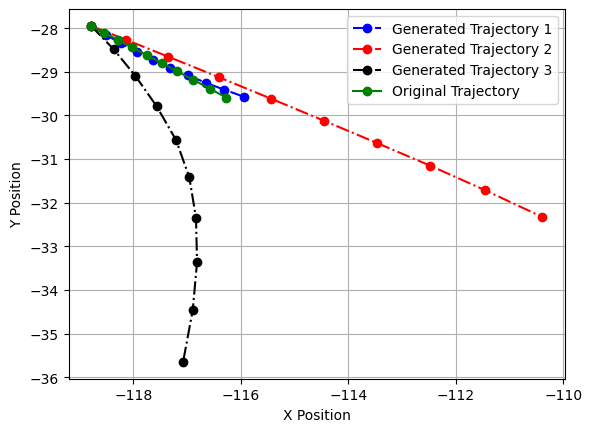

In [82]:

# Plot the original and interpolated trajectories
plt.figure()
plt.plot(gen1[:, 0], gen1[:, 1], 'b-.o', label='Generated Trajectory 1')
plt.plot(gen2[:, 0], gen2[:, 1], 'r-.o', label='Generated Trajectory 2')
plt.plot(gen3[:, 0], gen3[:, 1], 'k-.o', label='Generated Trajectory 3')
plt.plot(gt[:, 0], gt[:, 1], 'g-o', label='Original Trajectory')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()


In [73]:
gen1

array([[-118.78782334,  -27.94693492],
       [-118.51358226,  -28.15099256],
       [-118.2290954 ,  -28.34902322],
       [-117.93436276,  -28.54102691],
       [-117.62938435,  -28.72700362],
       [-117.31416016,  -28.90695336],
       [-116.9886902 ,  -29.08087612],
       [-116.65297446,  -29.2487719 ],
       [-116.30701295,  -29.41064071],
       [-115.95080566,  -29.56648254]])

In [72]:
gen1[1:]

array([[-118.51358226,  -28.15099256],
       [-118.2290954 ,  -28.34902322],
       [-117.93436276,  -28.54102691],
       [-117.62938435,  -28.72700362],
       [-117.31416016,  -28.90695336],
       [-116.9886902 ,  -29.08087612],
       [-116.65297446,  -29.2487719 ],
       [-116.30701295,  -29.41064071],
       [-115.95080566,  -29.56648254]])

In [61]:
gen1 = np.array([
    [-118.78782334,  -27.94693492],
    [-117.47305298,  -28.81773186],
    [-115.95080566,  -29.56648254]
])

gen2 = np.array([
    [-118.78782334,  -27.94693492],
    [-117.52101898,  -28.56824875],
    [-115.82861328,  -29.4161129 ],
    [-114.06791687,  -30.31990814],
    [-112.27102661,  -31.26221466],
    [-110.39716339,  -32.32287979]
])

gen3 = np.array([
    [-118.78782334,  -27.94693492],
    [-117.8640976 ,  -29.2577076 ],
    [-117.06825256,  -30.97887039],
    [-116.81121826,  -33.09387207],
    [-117.07551575,  -35.64902878]
])

gt = np.array([
    [-118.78782334,  -27.94693492],
    [-117.61347336,  -28.70616014],
    [-116.2698075 ,  -29.59005175]
])

## Imports

In [23]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import skimage
import cv2
from statistics import mean


## Plots

#### 1.a) Plot scenarios from generated padded samples 

In [ ]:
data_real_dir = '/data/tii/data/nuscenes_trainval_clean_test/'
data_gen_dir = '/data/ahmed.ghorbel/workdir/autod/TrafficDiffuser/results/TrafficDiffuser-B/samples/'

for l_real, l_gen in zip(sorted(os.listdir(data_real_dir)), sorted(os.listdir(data_gen_dir))):
    print(l_real)
    print(l_gen)
    data_real, data_gen = np.load(os.path.join(data_real_dir, l_real)), np.load(os.path.join(data_gen_dir, l_gen))
    data_hist, data_future = data_real[:, :8, :], data_real[:, 7:, :]
    print(f'Real data has shape: {data_real.shape}, and generated data has shape {data_gen.shape}')

    # Loop through each scene and plot separately
    plt.figure() 
    epsilon = 0.1   # to discard the predicted padding because its not exactely equal to zero
    #for ag in range(data_future.shape[0]):  # Loop through each agent in the scene (MAX to 9 in clean testset)    
    for ag in range(10):    
        for sample_idx in range(10):
            #-- add the first timestep of data_future to have a continuity between hist and gen trajs
            agent_gen = np.concatenate((data_future[ag, 0:1, :], data_gen[sample_idx, ag, :, :]), axis=0)   
            valid_agent_gen = agent_gen[(np.abs(agent_gen[:, 0]) > epsilon) & (np.abs(agent_gen[:, 1]) > epsilon)]
            plt.plot(valid_agent_gen[:, 0], valid_agent_gen[:, 1], 'b-.o', linewidth=1.2, markersize=2.8)
        
        agent_hist, agent_future = data_hist[ag], data_future[ag] 
        valid_agent_future = agent_future[(agent_future[:, 0] != 0.0) & (agent_future[:, 1] != 0.0)]
        plt.plot(valid_agent_future[:, 0], valid_agent_future[:, 1], 'g-o', linewidth=1.2, markersize=2.8)

        valid_agent_hist = agent_hist[(agent_hist[:, 0] != 0.0) & (agent_hist[:, 1] != 0.0)]
        plt.plot(valid_agent_hist[:, 0], valid_agent_hist[:, 1], 'k-o', linewidth=1.2, markersize=2.8)
        
    plt.show() 
    plt.close()  

In [ ]:
data_real_dir = '/data/tii/data/nuscenes_trainval_clean_test/'
data_gen_dir = '/data/ahmed.ghorbel/workdir/autod/TrafficDiffuser/results/007-TrafficDiffuser-B/samples/'

for l_real, l_gen in zip(sorted(os.listdir(data_real_dir)), sorted(os.listdir(data_gen_dir))):
    print(l_real)
    print(l_gen)
    data_real, data_gen = np.load(os.path.join(data_real_dir, l_real)), np.load(os.path.join(data_gen_dir, l_gen))
    data_hist, data_future = data_real[:, :8, :], data_real[:, 7:, :]
    print(f'Real data has shape: {data_real.shape}, and generated data has shape {data_gen.shape}')

    # Loop through each scene and plot separately
    plt.figure() 
    epsilon = 0.1   # to discard the predicted padding because its not exactely equal to zero
    #for ag in range(data_future.shape[0]):  # Loop through each agent in the scene (MAX to 9 in clean testset)    
    for ag in range(10):    
        for sample_idx in range(10):
            #-- add the first timestep of data_future to have a continuity between hist and gen trajs
            agent_gen = np.concatenate((data_future[ag, 0:1, :], data_gen[sample_idx, ag, :, :]), axis=0)   
            valid_agent_gen = agent_gen[(np.abs(agent_gen[:, 0]) > epsilon) & (np.abs(agent_gen[:, 1]) > epsilon)]
            plt.plot(valid_agent_gen[:, 0], valid_agent_gen[:, 1], 'b-.o', linewidth=1.2, markersize=2.8)
        
        agent_hist, agent_future = data_hist[ag], data_future[ag] 
        valid_agent_future = agent_future[(agent_future[:, 0] != 0.0) & (agent_future[:, 1] != 0.0)]
        plt.plot(valid_agent_future[:, 0], valid_agent_future[:, 1], 'g-o', linewidth=1.2, markersize=2.8)

        valid_agent_hist = agent_hist[(agent_hist[:, 0] != 0.0) & (agent_hist[:, 1] != 0.0)]
        plt.plot(valid_agent_hist[:, 0], valid_agent_hist[:, 1], 'k-o', linewidth=1.2, markersize=2.8)
        
    plt.show() 
    plt.close()  

#### 1.b) Plot scenarios from generated non-padded samples 

In [ ]:
data_real_dir = '/data/tii/data/nuscenes_trainval_veh_clean_test/'
data_gen_dir = '/data/ahmed.ghorbel/workdir/autod/TrafficDiffuser/results/008-TrafficDiffuser-B/samples/'

for l_real, l_gen in zip(sorted(os.listdir(data_real_dir)), sorted(os.listdir(data_gen_dir))):
    print(l_real)
    print(l_gen)
    data_real, data_gen = np.load(os.path.join(data_real_dir, l_real)), np.load(os.path.join(data_gen_dir, l_gen))
    data_hist, data_future = data_real[:, :8, :], data_real[:, 7:, :]
    print(f'Real data has shape: {data_real.shape}, and generated data has shape {data_gen.shape}')

    # Loop through each scene and plot separately
    plt.figure() 
    for ag in [i for i in range(data.shape[0])]:  # Loop through each agent in the scene (MAX to 9 in clean testset)    
        
        for sample_idx in range(10):
            agent_gen = np.concatenate((data_future[ag, 0:1, :], data_gen[sample_idx, ag, :, :]), axis=0)   
            plt.plot(agent_gen[:, 0], agent_gen[:, 1], 'b-.o', linewidth=1.2, markersize=2.8)
        
        agent_hist, agent_future = data_hist[ag], data_future[ag] 
        
        plt.plot(agent_future[:, 0], agent_future[:, 1], 'g-o', linewidth=1.2, markersize=2.8)
        
        plt.plot(agent_hist[:, 0], agent_hist[:, 1], 'k-o', linewidth=1.2, markersize=2.8)
        
    plt.show() 
    plt.close()  

#### 2) Plot padded scenarios from a dataset without generations

In [ ]:
data_real_dir = '/data/tii/data/nuscenes_trainval_clean_test/'

for l_real in sorted(os.listdir(data_real_dir)):
    print(l_real)
    data_real = np.load(os.path.join(data_real_dir, l_real))
    data_hist, data_future = data_real[:, :8, :], data_real[:, 7:, :]
    print(f'Real data has shape: {data_real.shape}')

    # Loop through each scene and plot separately
    plt.figure() 
    for ag in [i for i in range(data.shape[0])]:  # Loop through each agent in the scene   
        agent_hist, agent_future = data_hist[ag], data_future[ag] 
        
        valid_agent_future = agent_future[(agent_future[:, 0] != 0.0) & (agent_future[:, 1] != 0.0)]
        plt.plot(valid_agent_future[:, 0], valid_agent_future[:, 1], 'g-o', linewidth=1.2, markersize=2.8)
        
        valid_agent_hist = agent_hist[(agent_hist[:, 0] != 0.0) & (agent_hist[:, 1] != 0.0)]
        plt.plot(valid_agent_hist[:, 0], valid_agent_hist[:, 1], 'k-o', linewidth=1.2, markersize=2.8)
        
    plt.show() 
    plt.close()  

#### 3) Plot padded and non-padded dataset (multicolors)

/data/tii/data/nuscenes_trainval_clean_train/sd_nuscenes_v1.0-trainval_scene-0001.npy
(46, 13, 2)
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_

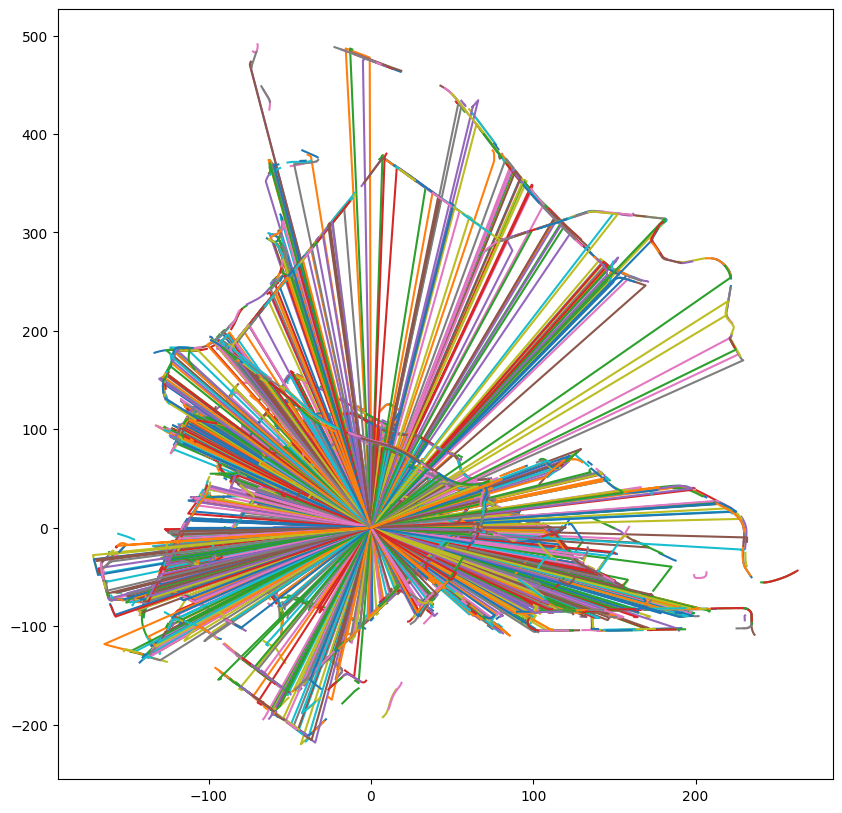

In [88]:
plt.figure(figsize=(10, 10))
data_dir = '/data/tii/data/nuscenes_trainval_clean_train'
for filename in os.listdir(data_dir):
    if filename.endswith('.npy'):
        # Load .npy file
        file_path = os.path.join(data_dir, filename)
        print(file_path)
        npy_data = np.load(file_path)
        print(npy_data.shape)
        for ag in range(npy_data.shape[0]):
            agent_traj = npy_data[ag, :, :]
            print(agent_traj.shape)
            print(filename)
            plt.plot(agent_traj[:, 0], agent_traj[:, 1])

/data/tii/data/nuscenes_trainval_clean_train/sd_nuscenes_v1.0-trainval_scene-0001.npy
(11, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(11, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(11, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(13, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.npy
(0, 2)
sd_nuscenes_v1.0-trainval_scene-0001.np

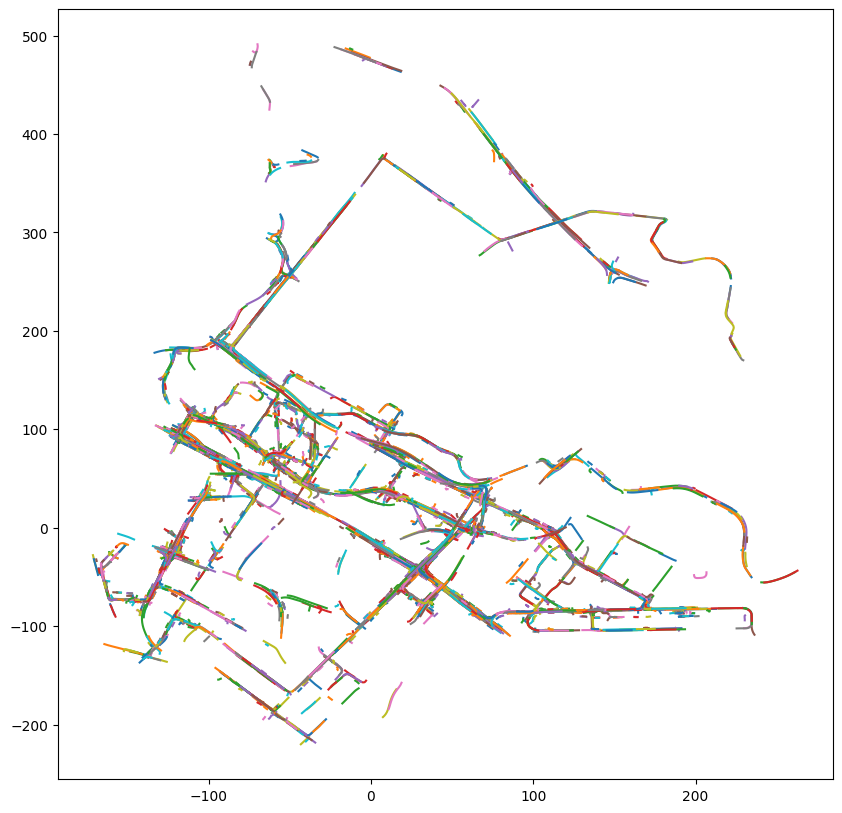

In [89]:
plt.figure(figsize=(10, 10))
data_dir = '/data/tii/data/nuscenes_trainval_clean_train'
for filename in os.listdir(data_dir):
    if filename.endswith('.npy'):
        # Load .npy file
        file_path = os.path.join(data_dir, filename)
        print(file_path)
        npy_data = np.load(file_path)
        for ag in range(npy_data.shape[0]):
            agent_traj = npy_data[ag, :, :]
            valid_xy = agent_traj[(agent_traj[:, 0] != 0.0) & (agent_traj[:, 1] != 0.0)]
            print(valid_xy.shape)
            print(filename)
            plt.plot(valid_xy[:, 0], valid_xy[:, 1])

## Data process

#### 1- Sample the sequence length to 13. 

In [79]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def process_npy_files(input_directory, output_directory, step=12):
    """Process each grouped npy file to replace padded values and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, data[:, ::step, :])
        print(f"Cropped, sampled, and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'

    process_npy_files(input_directory, output_directory, step=12)

if __name__ == "__main__":
    main()

Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0001.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0002.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0003.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0004.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0005.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0006.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0007.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0008.npy
Cropped, sampled, and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainva

#### 2- Normalize padded or not multi agent data 

In [81]:
import os
import numpy as np

def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def calculate_mean_std_excluding_padding(input_directory):
    """Calculate the mean and standard deviation for x and y positions across all files, excluding zero padding."""
    npy_files = list_npy_files(input_directory)
    all_non_zero_values = []

    for file_path in npy_files:
        data = np.load(file_path)
        # Mask out the zero-padded values
        mask = np.any(data != 0, axis=-1)  # Assuming D=2 for x, y
        non_zero_data = data[mask]
        all_non_zero_values.append(non_zero_data)

    all_non_zero_values = np.concatenate(all_non_zero_values, axis=0)  # Combine all non-zero data
    print(all_non_zero_values.shape)
    mean = np.mean(all_non_zero_values, axis=0)
    std = np.std(all_non_zero_values, axis=0)
    return mean, std

def calculate_mean_std(input_directory):
    """Calculate the mean and standard deviation for x and y positions across all files."""
    npy_files = list_npy_files(input_directory)
    all_data = []

    for file_path in npy_files:
        data = np.load(file_path)
        all_data.append(data)

    all_data = np.concatenate(all_data, axis=0)
    mean = np.mean(all_data, axis=(0, 1))
    std = np.std(all_data, axis=(0, 1))
    return mean, std

def normalize_and_standardize_excluding_padding(data, mean, std):
    """Normalize and standardize the positions x and y in the data, excluding zero padding."""
    mask = np.any(data != 0, axis=-1)
    normalized_standardized_data = np.copy(data)
    normalized_standardized_data[mask] = (data[mask] - mean) / std
    return normalized_standardized_data

def process_grouped_npy_files(input_directory, output_directory, mean, std):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        normalized_standardized_data = normalize_and_standardize_excluding_padding(data, mean, std)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, normalized_standardized_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    
    mean, std = calculate_mean_std_excluding_padding(input_directory)
    print(f'Calculate mean and std while considering padded values: (mean: {mean}, std: {std})')
    
    #mean, std = calculate_mean_std(input_directory)
    #print(f'Calculate mean and std without considering padded values: (mean: {mean}, std: {std})')

    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, mean, std)

if __name__ == "__main__":
    main()


(291827, 2)
Calculate mean and std while considering padded values: (mean: [1117.28378752 1231.38483692], std: [600.29805033 427.54111417])
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0001.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0002.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0003.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0004.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0005.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0006.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0007.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0008.npy
Processed and saved 

#### 3- Scale the normalized dataset

In [82]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def process_grouped_npy_files(input_directory, output_directory, scale_factor):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        scaled_data = data * scale_factor
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, scaled_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'

    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, scale_factor=100)

if __name__ == "__main__":
    main()

Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0001.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0002.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0003.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0004.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0005.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0006.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0007.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0008.npy
Processed and saved /data/tii/data/nuscenes_trainval_update_npy/sd_nuscenes_v1.0-trainval_scene-0009.npy
Processed and saved /data/tii/data/nuscenes_trainval_up

#### 4- Remove stastionary agents from padded dataset

In [84]:
import os
import numpy as np

def remove_stationary_agents(data, min_distance=0.7):
    """
    Remove stationary agents from a dataset while ignoring padded data.

    Parameters:
        data (numpy.ndarray): A dataset containing trajectories of agents.
                              Expected shape is (N, L, D) where N is the number of agents,
                              L is the sequence length, and D is the dimension (e.g., x, y positions).
        min_distance (float): The minimum total distance an agent must move to not be considered stationary.

    Returns:
        numpy.ndarray: A new dataset with stationary agents removed.
    """
    # Split data into history and future parts
    data_history = data[:, :8, :]  # Shape: (N, 8, D)
    data_future = data[:, 8:, :]   # Shape: (N, L-8, D)

    # Calculate total movement for history part
    non_padded_mask_history = ~(np.all(data_history == 0., axis=2))
    diffs_history = np.diff(data_history, axis=1)
    valid_diffs_mask_history = non_padded_mask_history[:, :-1] & non_padded_mask_history[:, 1:]
    valid_diffs_history = diffs_history * valid_diffs_mask_history[:, :, np.newaxis]
    distances_history = np.linalg.norm(valid_diffs_history, axis=2)
    total_movement_history = distances_history.sum(axis=1)

    # Calculate total movement for future part
    non_padded_mask_future = ~(np.all(data_future == 0., axis=2))
    diffs_future = np.diff(data_future, axis=1)
    valid_diffs_mask_future = non_padded_mask_future[:, :-1] & non_padded_mask_future[:, 1:]
    valid_diffs_future = diffs_future * valid_diffs_mask_future[:, :, np.newaxis]
    distances_future = np.linalg.norm(valid_diffs_future, axis=2)
    total_movement_future = distances_future.sum(axis=1)

    # Identify non-stationary agents in both history and future
    non_stationary_agents = (total_movement_future > min_distance) & (total_movement_history > min_distance)

    # Filter out the stationary agents
    filtered_data = data[non_stationary_agents]

    return filtered_data


def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]


def process_grouped_npy_files(input_directory, output_directory, min_distance):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        filtered_data = remove_stationary_agents(data, min_distance=min_distance)
        if filtered_data.shape[0] != 0:  # Only save non-empty filtered data
            output_path = os.path.join(output_directory, os.path.basename(file_path))
            np.save(output_path, filtered_data)
            print(f"Processed and saved {output_path}")
            print(f"Shape of filtered data {filtered_data.shape}")
        else:
            print(f"No non-stationary agents found in {file_path}")


def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update'
    process_grouped_npy_files(input_directory, output_directory, min_distance=0.4)


if __name__ == "__main__":
    main()


Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0001.npy
Shape of filtered data (4, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0002.npy
Shape of filtered data (2, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0003.npy
Shape of filtered data (14, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0004.npy
Shape of filtered data (4, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0005.npy
Shape of filtered data (2, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0006.npy
Shape of filtered data (3, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_update/sd_nuscenes_v1.0-trainval_scene-0007.npy
Shape of filtered data (18, 13, 2)
Processed and saved /data/tii/data/nuscenes_trainval_

#### 5- Pad clean scenarios to max number of agents

In [4]:
# Paths to your dataset
input_directory = '/data/tii/data/nuscenes_trainval_clean_train'

# Step 1: Determine the maximum, minimum, second minimum, and third minimum N
max_N = 0
min_N = float('inf')
unique_N = set()  # To store unique N values

for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        data = np.load(file_path)
        N, L, D = data.shape
        # Update max and min N
        max_N = max(max_N, N)
        min_N = min(min_N, N)
        # Store the unique N values
        unique_N.add(N)

# Convert the set of unique N values to a sorted list
sorted_N = sorted(unique_N)

# Get the second and third minimum if they exist
second_min_N = sorted_N[1] if len(sorted_N) > 1 else None
third_min_N = sorted_N[2] if len(sorted_N) > 2 else None

# Get the second and third maximum if they exist
second_max_N = sorted_N[-2] if len(sorted_N) > 1 else None
third_max_N = sorted_N[-3] if len(sorted_N) > 2 else None

print(f"Maximum number of agents (N) across all files: {max_N}")
print(f"Second maximum number of agents (N): {second_max_N}")
print(f"Third maximum number of agents (N): {third_max_N}")

print(f"Minimum number of agents (N) across all files: {min_N}")
print(f"Second minimum number of agents (N): {second_min_N}")
print(f"Third minimum number of agents (N): {third_min_N}")

""" for veh_clean_train and test and test before padding
Maximum number of agents (N) across all files: 19
Second maximum number of agents (N): 15
Third maximum number of agents (N): 14
Minimum number of agents (N) across all files: 1
Second minimum number of agents (N): 2
Third minimum number of agents (N): 3

Maximum number of agents (N) across all files: 9
Second maximum number of agents (N): 8
Third maximum number of agents (N): 7
Minimum number of agents (N) across all files: 1
Second minimum number of agents (N): 2
Third minimum number of agents (N): 3
"""

Maximum number of agents (N) across all files: 46
Second maximum number of agents (N): None
Third maximum number of agents (N): None
Minimum number of agents (N) across all files: 46
Second minimum number of agents (N): None
Third minimum number of agents (N): None


' for veh_clean_train and test and test before padding\nMaximum number of agents (N) across all files: 19\nSecond maximum number of agents (N): 15\nThird maximum number of agents (N): 14\nMinimum number of agents (N) across all files: 1\nSecond minimum number of agents (N): 2\nThird minimum number of agents (N): 3\n\nMaximum number of agents (N) across all files: 9\nSecond maximum number of agents (N): 8\nThird maximum number of agents (N): 7\nMinimum number of agents (N) across all files: 1\nSecond minimum number of agents (N): 2\nThird minimum number of agents (N): 3\n'

In [86]:
# Paths to your dataset
input_directory = '/data/tii/data/nuscenes_trainval_update'
output_directory = '/data/tii/data/nuscenes_trainval'
os.makedirs(output_directory, exist_ok=True)

max_N = 49
# Step 2: Pad each file to max_N
for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        data = np.load(file_path)
        N, L, D = data.shape
        
        if N < max_N:
            # Create a new array with the shape (max_N, L, D) and fill it with zeros
            padded_data = np.zeros((max_N, L, D))
            
            # Copy the original data into the new array
            padded_data[:N, :, :] = data
            
            # Save the padded data
            output_path = os.path.join(output_directory, filename)
            np.save(output_path, padded_data)
        else:
            # If no padding is needed, just copy the original file to the output directory
            output_path = os.path.join(output_directory, filename)
            np.save(output_path, data)

print("Padding completed and saved to the output directory.")

Padding completed and saved to the output directory.


#### 6- train test split

In [87]:
import os
import shutil

def move_matching_files(dir_A, dir_B, dir_D):
    """
    Move files from dir_A to dir_D where the filenames match those in dir_B.

    Parameters:
    dir_A (str): The source directory from which to move files.
    dir_B (str): The reference directory to check for matching filenames.
    dir_D (str): The destination directory where files will be moved.
    """

    # Ensure the destination directory exists
    os.makedirs(dir_D, exist_ok=True)

    # Get the set of filenames in dir_B
    files_in_B = set(os.listdir(dir_B))

    # Iterate over files in dir_A
    for filename in os.listdir(dir_A):
        if filename in files_in_B:
            # If a matching file is found, construct full paths
            source_path = os.path.join(dir_A, filename)
            destination_path = os.path.join(dir_D, filename)

            # Move the file from dir_A to dir_D
            shutil.move(source_path, destination_path)
            print(f"Moved: {filename} from {dir_A} to {dir_D}")

if __name__ == "__main__":
    dir_A = '/data/tii/data/nuscenes_trainval_clean_train'  
    dir_B = '/data/tii/data/nuscenes_trainval_veh_clean_test'  
    dir_D = '/data/tii/data/nuscenes_trainval_clean_test'  

    move_matching_files(dir_A, dir_B, dir_D)


Moved: sd_nuscenes_v1.0-trainval_scene-0004.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0007.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0010.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0013.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0014.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0015.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_trainval_clean_test
Moved: sd_nuscenes_v1.0-trainval_scene-0018.npy from /data/tii/data/nuscenes_trainval_clean_train to /data/tii/data/nuscenes_train

#### 0- Other

##### Replace padded values with saturation

In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def replace_padded_values(data):
    """Replace padded values (0.0) with the first next or previous non-zero (x, y) values."""
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # If current value is zero, find the next or previous non-zero value
            if np.all(data[i, j] == 0):
                # Find next non-zero value
                k = j + 1
                while k < data.shape[1] and np.all(data[i, k] == 0):
                    k += 1
                
                if k < data.shape[1]:
                    data[i, j] = data[i, k]
                else:
                    # If no next non-zero value, find the previous non-zero value
                    k = j - 1
                    while k >= 0 and np.all(data[i, k] == 0):
                        k -= 1
                    
                    if k >= 0:
                        data[i, j] = data[i, k]
    
    return data

def process_grouped_npy_files(input_directory, output_directory):
    """Process each grouped npy file to replace padded values and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        modified_data = replace_padded_values(data)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, modified_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_veh_norm_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_veh_norm_satur_npy'

    process_grouped_npy_files(input_directory, output_directory)

if __name__ == "__main__":
    main()

##### Add padding to seq length

In [ ]:
# Define paths
input_directory = '/data/tii/data/nuscenes_trainval_veh_processed_maxag_npy'
output_directory = '/data/tii/data/nuscenes_trainval_veh_final_npy'
os.makedirs(output_directory, exist_ok=True)

# Define the desired sequence length after padding
desired_length = 20

# Function to pad sequences
def pad_sequence(sequence, pad_len, position):
    """
    Pad a sequence to the desired length.
    
    Args:
        sequence (np.ndarray): The original sequence of shape (L, D).
        pad_len (int): The total length to pad the sequence to.
        position (str): Where to add padding. Options are 'beginning', 'middle', 'end', or 'beginning_end'.
    
    Returns:
        np.ndarray: The padded sequence of shape (pad_len, D).
    """
    original_length = sequence.shape[0]
    pad_amount = pad_len - original_length
    pad_before = 0
    pad_middle = 0
    pad_after = 0
    
    if position == 'beginning':
        pad_before = pad_amount
    elif position == 'middle':
        pad_middle = pad_amount
    elif position == 'end':
        pad_after = pad_amount
    elif position == 'beginning_end':
        pad_before = pad_amount // 2
        pad_after = pad_amount - pad_before
    else:
        raise ValueError("Invalid position argument. Choose from 'beginning', 'middle', 'end', 'beginning_end'.")

    padding_before = np.zeros((pad_before, sequence.shape[1]))
    padding_middle = np.zeros((pad_middle, sequence.shape[1]))
    padding_after = np.zeros((pad_after, sequence.shape[1]))
    
    padded_sequence = np.vstack((padding_before, sequence[:sequence.shape[0]//2, :], padding_middle, sequence[sequence.shape[0]//2:, :], padding_after))
    return padded_sequence

# Loop through each file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        
        # Load the data
        data = np.load(file_path)
        
        # Initialize the padded data array
        padded_data = np.zeros((data.shape[0], desired_length, data.shape[2]))
        
        for i in range(data.shape[0]):
            # Decide where to add padding ('beginning', 'middle', 'end', 'beginning_end')
            positions = ['beginning', 'middle', 'end', 'beginning_end']
            pos = positions[i % len(positions)]  # For illustration, cycle through the positions
            
            padded_data[i] = pad_sequence(data[i], desired_length, pos)
        
        # Save the padded data
        output_path = os.path.join(output_directory, filename)
        np.save(output_path, padded_data)

print("Padding completed and saved to the output directory.")
